# Week 2: Advanced Financial Engineering (42108)

## Subject: ***Market Risk Measures (Value-at-Risk and Expected Shortfall)***

### Date: 08/02-2023

## Packages

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import gmean
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import collections as matcoll
import scipy.stats as sps
import math
import time
import matplotlib.colors as mcolors

# MAXIMUM LIKELIHOOD
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint

# RECOMMENDED IMPORTS FOR PROJECTS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from pmdarima.arima import auto_arima
import statsmodels.api as sm
from arch import arch_model

ModuleNotFoundError: No module named 'pmdarima'

## Introduction

Apart from suggested solutions, this notebook contains functions and method that can prove useful for you in general. E.g.,  we implement an example of maximum likelihood estimation.

## 1)

We start by downloading data for an arbtrary stock in S&P500. You can see a list of companies here: https://www.slickcharts.com/sp500.

In [3]:
START = "2012-01-01"
END = "2022-01-01"
INTERVAL = "1d" # Options: 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo and 3mo (m refers to minute, h refers to hour, d refers to day, wk refers to week and mo refers to month)

TICKERS = [
    "AMZN", # Amazon (CONSUMER DISCRETIONARY)
    "BMY"
]

stock_data = yf.download(
    tickers = TICKERS,
    start = START,
    end = END,
    interval = INTERVAL
).dropna()['Adj Close']

Results = np.zeros((8, 4))

[*********************100%***********************]  2 of 2 completed


Then we calculate the returns. We use real returns here.

In [4]:
AMZN_returns = stock_data['AMZN'].pct_change().dropna()*100
BMY_returns = stock_data['BMY'].pct_change().dropna()*100

Then we can find a moving average to see if the mean is stationary. The purpose of this is to get an idea of how representative past data is and choose model and period of past data. It is okay, if you just made a choice on data points for questions 3 onwards instead of making data analysis based on 2).

In [5]:
MA = 10

AMZN_mean_10d = [np.mean(AMZN_returns.values[i-MA:i]) for i in range(MA, len(AMZN_returns.values))]
AMZN_vol_10d = [np.std(AMZN_returns.values[i-MA:i]) for i in range(MA, len(AMZN_returns.values))]
AMZN_mean_dates = AMZN_returns.index[MA:]

## 2)

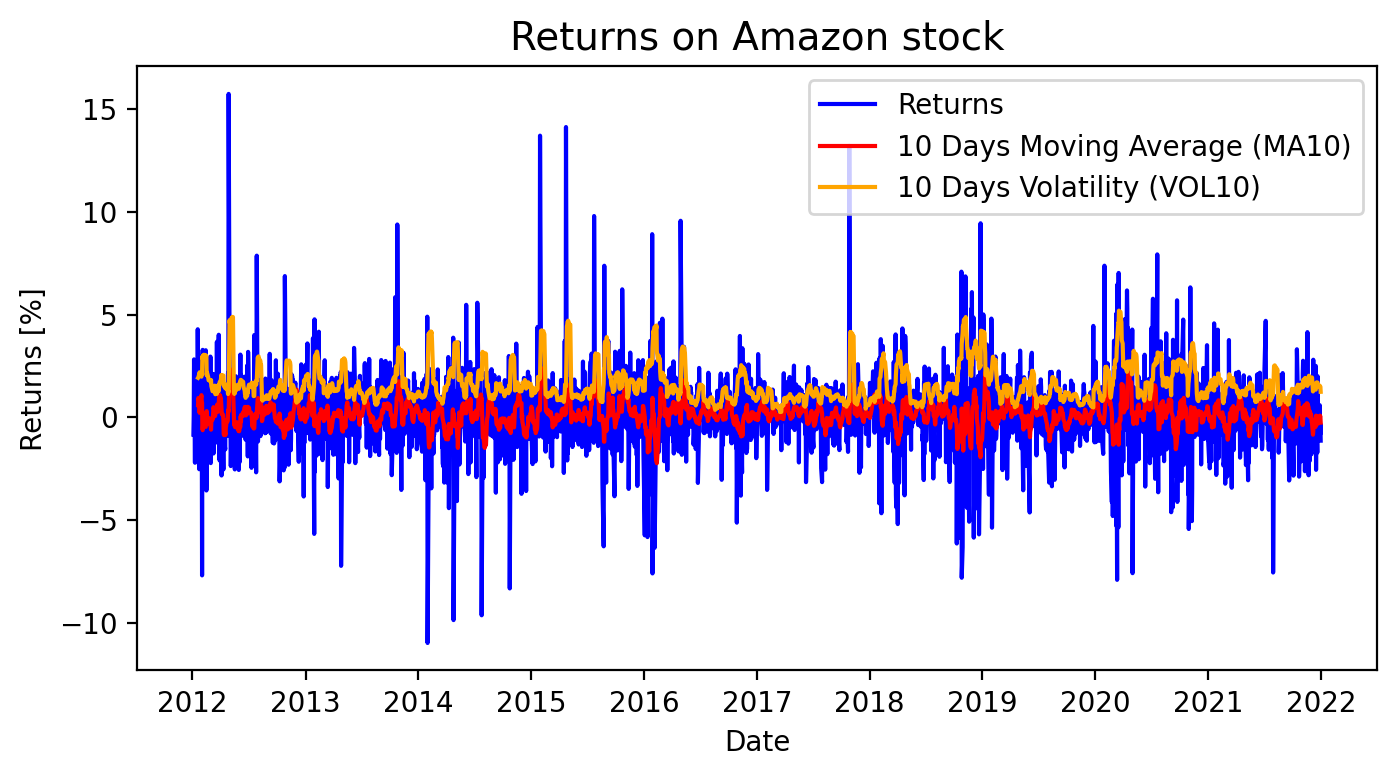

In [6]:
plt.figure(figsize=(8,4), dpi=200)
plt.plot(AMZN_returns.index, AMZN_returns.values, color = 'blue', label = "Returns")
plt.plot(AMZN_mean_dates, AMZN_mean_10d, color = 'red', label = "{} Days Moving Average (MA{})".format(MA, MA))
plt.plot(AMZN_mean_dates, AMZN_vol_10d, color = 'orange', label = "{} Days Volatility (VOL{})".format(MA, MA))
plt.xlabel("Date")
plt.ylabel("Returns [%]")
plt.title("Returns on Amazon stock", fontsize = 14)
plt.legend()
plt.show()

The time series is not $\textit{second-order stationary}$, because the mean (first-order centralized moment) and the variance (second-order centralized moment) are varying with time. In addition, the definition also requires that and autocovariance (second-order centralized cross-moment) is constant for the same lags. However, increasing the number of days we include stabilizes the moments.

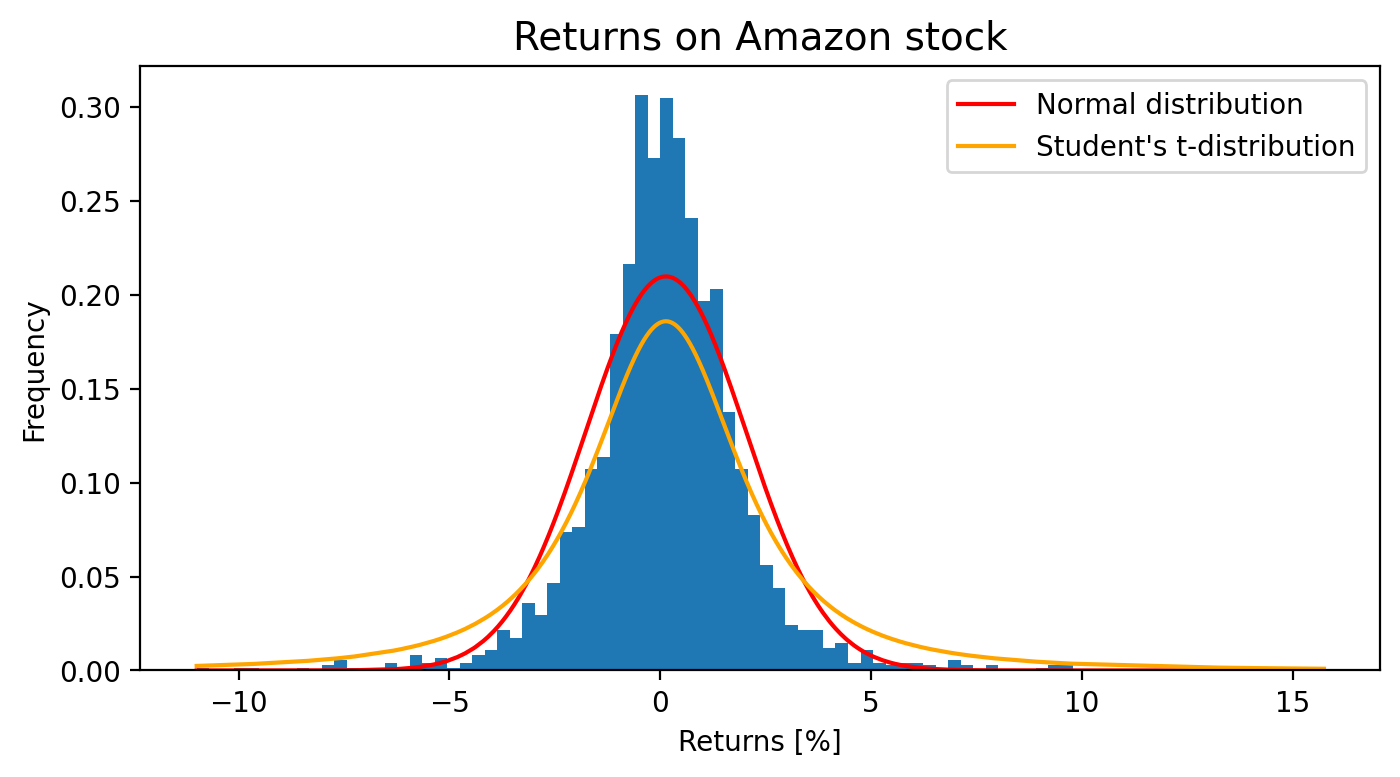

In [7]:
plt.figure(figsize=(8,4), dpi=200)
plt.hist(AMZN_returns.values, bins = 90, density = True)
plt.plot(np.sort(AMZN_returns.values), sps.norm.pdf(np.sort(AMZN_returns.values), loc=np.mean(AMZN_returns.values), scale=np.std(AMZN_returns.values)), color = 'red', label = "Normal distribution")
plt.plot(np.sort(AMZN_returns.values), sps.t.pdf(np.sort(AMZN_returns.values), 2, loc=np.mean(AMZN_returns.values), scale=np.std(AMZN_returns.values)), color = 'orange', label = "Student's t-distribution")
plt.xlabel("Returns [%]")
plt.ylabel("Frequency")
plt.title("Returns on Amazon stock", fontsize = 14)
plt.legend()
plt.show()

## 3) Non-Parametric Assumption (*Sometimes referred to as Historical Simulation*)

In the non-parametric assumption, we do not define a model structure. Instead, we use the observed distribution.

Value at Risk ($V$) for T days is defined as $\mathbb{P}[\mathcal{R} \leq -V] = 1 - \alpha$, where $\mathcal{R} = P_{T} - P_{0}$ (revenue or P\&L is just difference in portfolio values). $1-\alpha$ is the confidence level (often 99%, 97,5%, 95%). Because returns are often more stable than differences, we use the fact that $V = P_0 \times v$, where $v$ represents the VaR measured in percent (see e.g., the slides). Then we are left with the challenge of finding the quantile of the returns distribution. We use Python to find the quantile (check p 555 in RM and percentile documentation for Python).



In [8]:
portfolioAtDayN = 100000 # Suppose we invest 100.000$ on day n
days = 252
alpha = 0.05 # "We are (1-alpha) sure that the loss will not exceed .."

# We can use the percentile (and lower interpolation - if you are curious about this, check the definition (19.2). Otherwise just accept it.)
VaR_95_percentage = -np.percentile(AMZN_returns.values[-days:]/100, alpha*100, interpolation='lower')
VaR_95_USD = portfolioAtDayN*VaR_95_percentage
# Convince yourself that this should be the same as the alpha*days smallest observation rounded up (again, if you are curious about this, check the definition (19.2). Otherwise just accept it. 
# If we have 252 trading days and alpha is 0.05, then we should have the 13th observation. As Python starts in 0, that means using the floor function to get the right index )
scenarios = np.sort(AMZN_returns.values[-days:]/100)
VaR_95_percentage_sort = -scenarios[math.floor(days*(alpha))]
# When we have sorted, it's also easy to find ES. You could also do something similar to the example in RM page 556.
ES_95_percentage = -np.mean(scenarios[0:math.floor(days*(alpha))])
ES_95_USD = portfolioAtDayN * ES_95_percentage

print("1 day (percentage) {}%-VaR: {} pct.".format(int((1-alpha)*100), round(VaR_95_percentage*100, 2)))
print("1 day (percentage) {}%-VaR: {} pct.".format(int((1-alpha)*100), round(VaR_95_percentage_sort*100, 2)))
print("1 day (USD) {}%-VaR: {} USD".format(int((1-alpha)*100), round(VaR_95_USD)))
print("1 day (percentage) {}%-ES: {} pct.".format(int((1-alpha)*100), round(ES_95_percentage*100, 2)))
print("1 day (USD) {}%-ES: {} USD".format(int((1-alpha)*100), round(ES_95_USD)))

# Saving these into a matrix
Results[0,0] = round(VaR_95_USD)
Results[0,1] = round(ES_95_USD)

# 99% VaR
alpha = 0.01 # "We are (1-alpha) sure that the loss will not exceed .."
VaR_99_percentage = -np.percentile(AMZN_returns.values[-days:]/100, alpha*100, interpolation='lower')
VaR_99_USD = portfolioAtDayN*VaR_99_percentage
ES_99_percentage = -np.mean(scenarios[0:math.floor(days*(alpha))])
ES_99_USD = portfolioAtDayN * ES_99_percentage

Results[0,2] = round(VaR_99_USD)
Results[0,3] = round(ES_99_USD)



1 day (percentage) 95%-VaR: 2.56 pct.
1 day (percentage) 95%-VaR: 2.56 pct.
1 day (USD) 95%-VaR: 2564 USD
1 day (percentage) 95%-ES: 3.33 pct.
1 day (USD) 95%-ES: 3329 USD


## 4) Parametric Assumption 1 (*Also referred to as Model-Based Approach with normal distribution or variance-covariance approach*)

In this part, we assume that the returns are normally distributed (... although we have seen that this assumption is bold...). Furthermore, we can assume that the mean of the returns is 0 or estimate the mean.

In [10]:
portfolioAtDayN = 100000 # Suppose we invest 100.000$ on day n
days = 252 # change this if you like - this is note changed when using t-distribution later in order to compare the two.
alpha = 0.05 # "We are (1-alpha) sure that the loss will not exceed .."
mean_return = 0 # Assumption - we could estimate this as well.

volatility = np.std(AMZN_returns.values[-days:]/100) # this is the standard deviation of daily returns
VaR_95_percentage = -volatility*sps.norm.ppf(alpha, loc=mean_return, scale=1)
VaR_95_USD = portfolioAtDayN*VaR_95_percentage
ES_95_percentage = volatility*(sps.norm.pdf(sps.norm.ppf(alpha, loc=mean_return, scale=1)))/(alpha)
ES_95_USD = portfolioAtDayN*ES_95_percentage

print("1 day (percentage) {}%-VaR: {} pct.".format(int((1-alpha)*100), round(VaR_95_percentage*100, 2)))
print("1 day (USD) {}%-VaR: {} USD".format(int((1-alpha)*100), round(VaR_95_USD)))
print("1 day (percentage) {}%-ES: {} pct.".format(int((1-alpha)*100), round(ES_95_percentage*100, 2)))
print("1 day (USD) {}%-ES: {} USD".format(int((1-alpha)*100), round(ES_95_USD)))

# Saving these into a matrix
Results[1,0] = round(VaR_95_USD)
Results[1,1] = round(ES_95_USD)

# 99% VaR
alpha = 0.01 # "We are (1-alpha) sure that the loss will not exceed .."
VaR_99_percentage = -volatility*sps.norm.ppf(alpha, loc=mean_return, scale=1)
VaR_99_USD = portfolioAtDayN*VaR_99_percentage
ES_99_percentage = volatility*(sps.norm.pdf(sps.norm.ppf(alpha, loc=mean_return, scale=1)))/(alpha)
ES_99_USD = portfolioAtDayN*ES_99_percentage

Results[1,2] = round(VaR_99_USD)
Results[1,3] = round(ES_99_USD)

1 day (percentage) 95%-VaR: 2.49 pct.
1 day (USD) 95%-VaR: 2491 USD
1 day (percentage) 95%-ES: 3.12 pct.
1 day (USD) 95%-ES: 3124 USD


## 5) Parametric Assumption 2 (*Model-Based Approach with t-distribution*)

## Estimating the t-distribution

In [13]:

start_time = time.time()
MLE = sps.t.fit(AMZN_returns.values[-days:])
terminal_time = time.time()

print("It took {}s to estimate the parameters. \n".format(int(terminal_time-start_time)))

print("The numerically estimated MLEs are (with optimize): \n")
print("Mean: {}".format(MLE[1]))
print("Scale: {}".format(MLE[2]))
print("Degrees of freedom: {}".format(MLE[0]))

It took 0s to estimate the parameters. 

The numerically estimated MLEs are (with optimize): 

Mean: 0.0439625147920589
Scale: 1.2577431935801948
Degrees of freedom: 6.520734560465279


Now that we have the parameter estimates, we can find the estimates for VaR and ES. Let's first plot (and compare with the earlier found normal distribution)

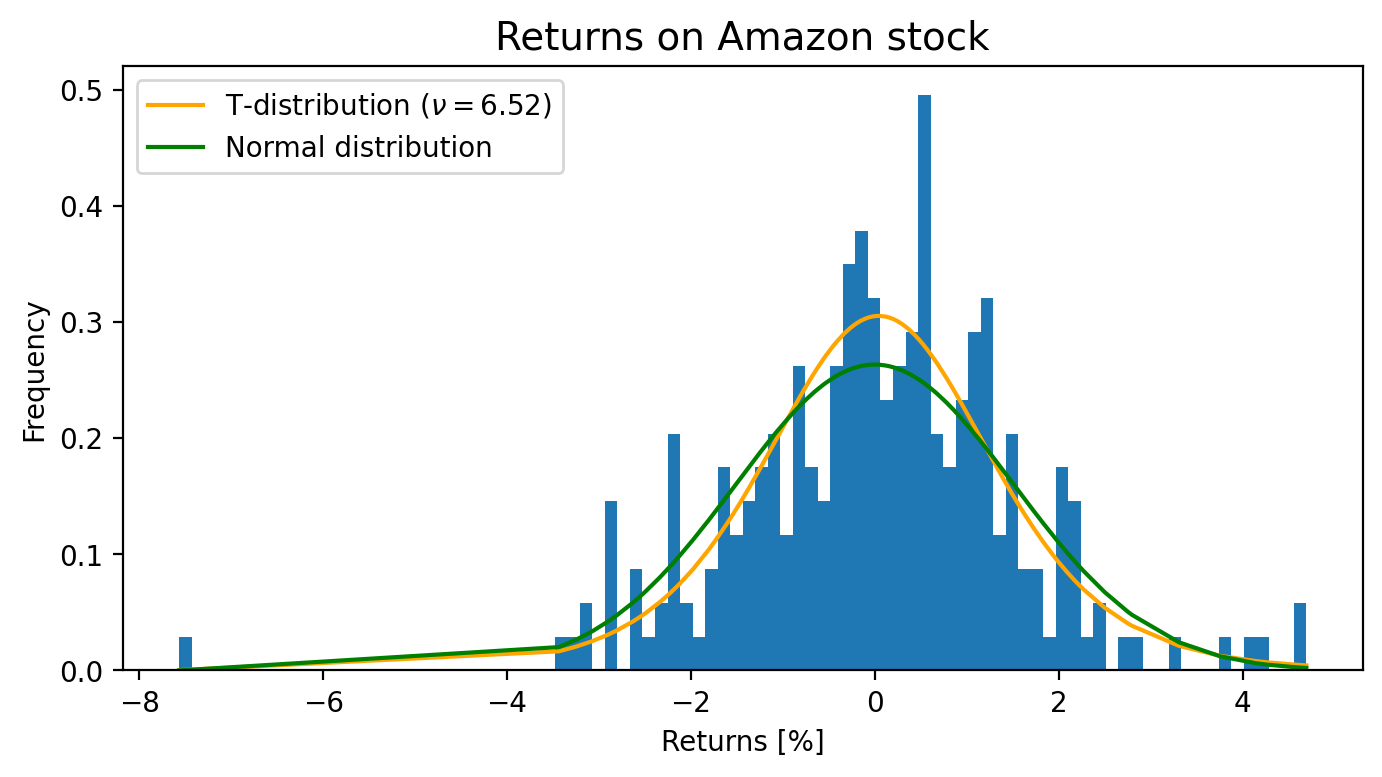

In [14]:
plt.figure(figsize=(8,4), dpi=200)
plt.hist(AMZN_returns.values[-days:], bins = 90, density = True)
plt.plot(np.sort(AMZN_returns.values[-days:]), sps.t.pdf(np.sort(AMZN_returns.values[-days:]), MLE[0], loc=MLE[1], scale=MLE[2]), color = 'orange', label = r'T-distribution $(\nu = {})$'.format(round(MLE[0],2)))
plt.plot(np.sort(AMZN_returns.values[-days:]), sps.norm.pdf(np.sort(AMZN_returns.values[-days:]), loc=mean_return*100, scale=volatility*100), color = 'green', label = 'Normal distribution')
plt.xlabel("Returns [%]")
plt.ylabel("Frequency")
plt.title("Returns on Amazon stock", fontsize = 14)
plt.legend()
plt.show()


As seen, the t-distribution allows for heavier tails. To find ES and VaR, we use page 557 in Ruppert & Matteson.

In [16]:
portfolioAtDayN = 100000 
alpha = 0.05 # "We are (1-alpha)% sure that the loss will not exceed .."


VaR_95_percentage = -sps.t.ppf(alpha, MLE[0], loc=MLE[1], scale=MLE[2])/100
VaR_95_USD = portfolioAtDayN*VaR_95_percentage
factor1 = (sps.t.pdf(sps.t.ppf(alpha, MLE[0]), MLE[0]))/alpha
factor2 = (MLE[0] + (sps.t.ppf(alpha, MLE[0])**2))/(MLE[0] - 1)
ES_95_percentage = (-1*MLE[1] + MLE[2]*factor1*factor2)/100
ES_95_USD = portfolioAtDayN*ES_95_percentage

print("1 day (percentage) {}%-VaR: {} pct.".format(int((1-alpha)*100), round(VaR_95_percentage*100, 2)))
print("1 day (USD) {}%-VaR: {} USD".format(int((1-alpha)*100), round(VaR_95_USD)))
print("1 day (percentage) {}%-ES: {} pct.".format(int((1-alpha)*100), round(ES_95_percentage*100, 2)))
print("1 day (USD) {}%-ES: {} USD".format(int((1-alpha)*100), round(ES_95_USD)))

# Saving these into a matrix
Results[2,0] = round(VaR_95_USD)
Results[2,1] = round(ES_95_USD)

# 99% VaR
alpha = 0.01 # "We are (1-alpha) sure that the loss will not exceed .."

VaR_99_percentage = -sps.t.ppf(alpha, MLE[0], loc=MLE[1], scale=MLE[2])/100
VaR_99_USD = portfolioAtDayN*VaR_99_percentage
factor1 = (sps.t.pdf(sps.t.ppf(alpha, MLE[0]), MLE[0]))/alpha
factor2 = (MLE[0] + (sps.t.ppf(alpha, MLE[0])**2))/(MLE[0] - 1)
ES_99_percentage = (-1*MLE[1] + MLE[2]*factor1*factor2)/100
ES_99_USD = portfolioAtDayN*ES_99_percentage

Results[2,2] = round(VaR_99_USD)
Results[2,3] = round(ES_99_USD)



1 day (percentage) 95%-VaR: 2.37 pct.
1 day (USD) 95%-VaR: 2366 USD
1 day (percentage) 95%-ES: 3.28 pct.
1 day (USD) 95%-ES: 3282 USD


The extreme quantiles are both higher than under normality assumption (heavier tails, makes sense!). 
The estimates are both lower than under historical simulation. While tails are heavier in the t-distribution, they are still "smooth" and do not account for bump-on-tail characteristics.

## 6) VaR and ES with GARCH

When we assume zeron mean, the returns are distributed the following way using a GARCH(p,q) model:

$$
r_{t} = a_{t} = \sigma_{t} \epsilon_{t} 
$$

where 

$$
\sigma_{t} = \sqrt{\omega + \sum_{i=1}^{p} \alpha_{i} a_{t-i}^{2} + \sum_{i=1}^{q} \beta_{i} \sigma_{t-j}^{2}}
$$

and $\epsilon_{t}$ is Gaussian white noise with unit variance.

In [17]:
garch = arch_model(AMZN_returns.values[-days:]/100, vol='garch', p=1, o=0, q=1)
garch_fitted = garch.fit()

NameError: name 'arch_model' is not defined

In [18]:
garch_forecast = garch_fitted.forecast(horizon=1, reindex=False)
variance = garch_forecast.variance.values[0][0]

NameError: name 'garch_fitted' is not defined

In [19]:
alpha = 0.05 # "We are (1-alpha) sure that the loss will not exceed .."
mean_return = 0 # Assumption - we could estimate an model for this, but let's not overdo it.

volatility = np.sqrt(variance)
VaR_95_percentage = -volatility*sps.norm.ppf(alpha, loc=mean_return, scale=1)
VaR_95_USD = portfolioAtDayN*VaR_95_percentage
ES_95_percentage = volatility*(sps.norm.pdf(sps.norm.ppf(alpha, loc=mean_return, scale=1)))/(alpha)
ES_95_USD = portfolioAtDayN*ES_95_percentage

print("1 day (percentage) {}%-VaR: {} pct.".format(int((1-alpha)*100), round(VaR_95_percentage*100, 2)))
print("1 day (USD) {}%-VaR: {} USD".format(int((1-alpha)*100), round(VaR_95_USD)))
print("1 day (percentage) {}%-ES: {} pct.".format(int((1-alpha)*100), round(ES_95_percentage*100, 2)))
print("1 day (USD) {}%-ES: {} USD".format(int((1-alpha)*100), round(ES_95_USD)))

# Saving these into a matrix
Results[3,0] = round(VaR_95_USD)
Results[3,1] = round(ES_95_USD)

# 99% VaR
alpha = 0.01 # "We are (1-alpha) sure that the loss will not exceed .."
VaR_99_percentage = -volatility*sps.norm.ppf(alpha, loc=mean_return, scale=1)
VaR_99_USD = portfolioAtDayN*VaR_99_percentage
ES_99_percentage = volatility*(sps.norm.pdf(sps.norm.ppf(alpha, loc=mean_return, scale=1)))/(alpha)
ES_99_USD = portfolioAtDayN*ES_99_percentage

Results[3,2] = round(VaR_99_USD)
Results[3,3] = round(ES_99_USD)

NameError: name 'variance' is not defined

We start by investigating the squared residuals.

## 7) Non-Parametric with Probability Weighting 

In the standard historical simulation approach, we assume that all observations are equally likely. However, it seems more appropriate to put higher weight on the most recent observations.

In [20]:
def probabilityWeighting(n=days, l=0.995):
    return np.array([((1 - l)*l**(n-i))/(1 - l**n) for i in range(1, n+1)])

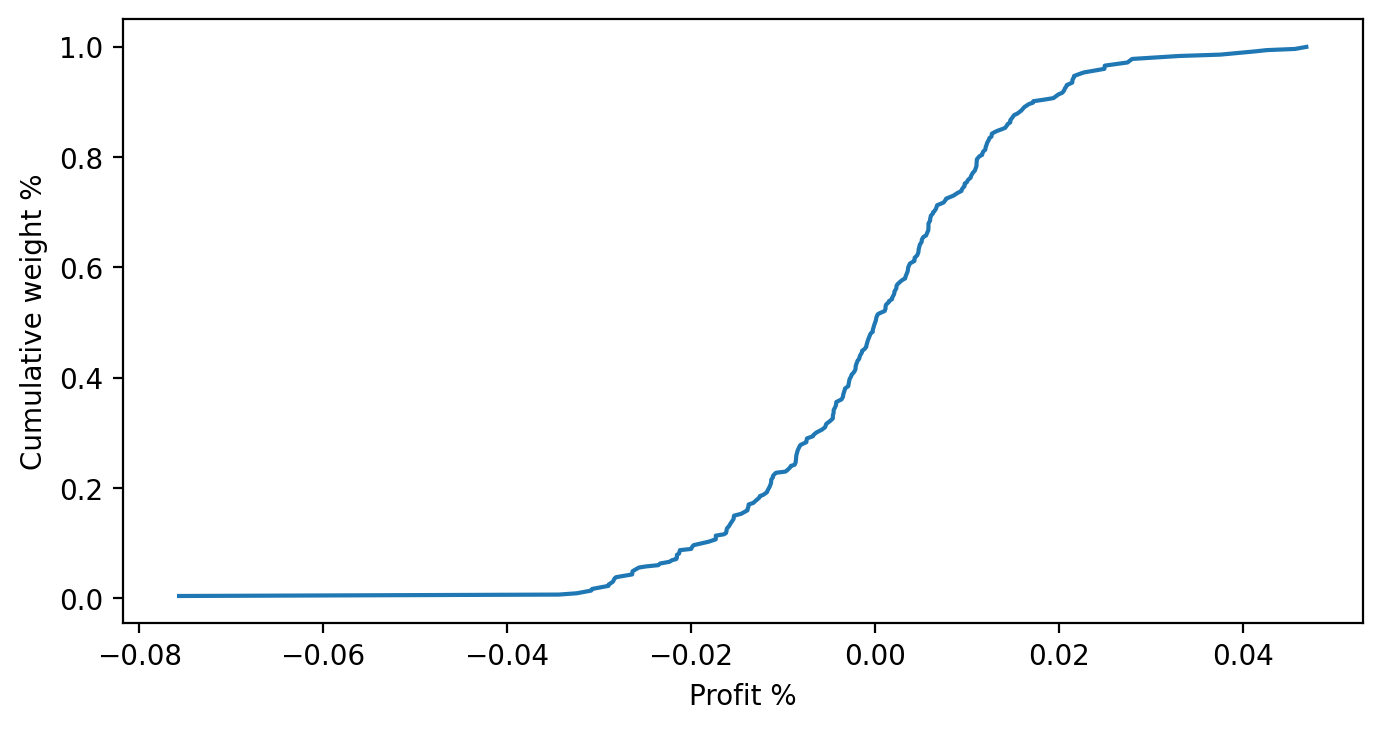

In [21]:
PW = probabilityWeighting(n=252)
scenarios = AMZN_returns.values[-days:]
data = pd.DataFrame({'Weights': PW, 'Accumulated Weights': PW, 'Scenarios': scenarios/100})
data = data.sort_values('Scenarios', ascending=True)
data['Accumulated Weights'] = np.cumsum(data['Weights'])

plt.figure(figsize=(8,4), dpi=200)
plt.plot(data['Scenarios'], data['Accumulated Weights'])
plt.xlabel("Profit %")
plt.ylabel("Cumulative weight %")
_ = None

Then we find the right index and locate VaR and calculate ES.

In [22]:
alpha = 0.05 # "We are (1-alpha) sure that the loss will not exceed .."

idx = np.where(data['Accumulated Weights'] > alpha)[0][0]
VaR_95_percentage = -data['Scenarios'].values[idx]
ES_95_percentage =-((data['Scenarios'].values[:idx-1]* data['Weights'].values[:idx-1]).sum() + (alpha - data['Accumulated Weights'].values[idx-1]) * data['Weights'].values[idx])/alpha
VaR_95_USD = portfolioAtDayN*VaR_95_percentage
ES_95_USD = portfolioAtDayN*ES_95_percentage

print("1 day (percentage) {}%-VaR: {} pct.".format(int((1-alpha)*100), round(VaR_95_percentage*100, 2)))
print("1 day (USD) {}%-VaR: {} USD".format(int((1-alpha)*100), round(VaR_95_USD)))
print("1 day (percentage) {}%-ES: {} pct.".format(int((1-alpha)*100), round(ES_95_percentage*100, 2)))
print("1 day (USD) {}%-ES: {} USD".format(int((1-alpha)*100), round(ES_95_USD)))

# Saving these into a matrix
Results[4,0] = round(VaR_95_USD)
Results[4,1] = round(ES_95_USD)

# 99% VaR
idx = np.where(data['Accumulated Weights'] > alpha)[0][0]
VaR_99_percentage = -data['Scenarios'].values[idx]
ES_99_percentage =-((data['Scenarios'].values[:idx-1]* data['Weights'].values[:idx-1]).sum() + (alpha - data['Accumulated Weights'].values[idx-1]) * data['Weights'].values[idx])/alpha
VaR_99_USD = portfolioAtDayN*VaR_99_percentage
ES_99_USD = portfolioAtDayN*ES_99_percentage


Results[4,2] = round(VaR_99_USD)
Results[4,3] = round(ES_99_USD)

1 day (percentage) 95%-VaR: 2.56 pct.
1 day (USD) 95%-VaR: 2564 USD
1 day (percentage) 95%-ES: 2.9 pct.
1 day (USD) 95%-ES: 2899 USD


## 8) Non-Parametric with Volatility Adjustments

The volatility for day t is found using an EWMA model. Another approach is to use the GARCH model (this was already estimated earlier). 

The EWMA says that volatility evolves according to $$\sigma_{t+1}^2 = \lambda \sigma^2_t + (1-\lambda)r^2_t$$ where $\lambda$ is around 0.95 (you can try different settings). This can easily be extended to a multivariate setting if replacing with covariance matrix and multiplication of $r_tr_t'$. It's a bit simple that the GARCH model, but the principle is similar. If (absolute) returns are larger than the volatility, the volatility increases. Otherwise it decreases. We need a starting point for the variance, then a burn-in period to get the "rigth" value of $\sigma$ for the first time point in our sample and then we need to extract the daily volatilities and scale the returns.

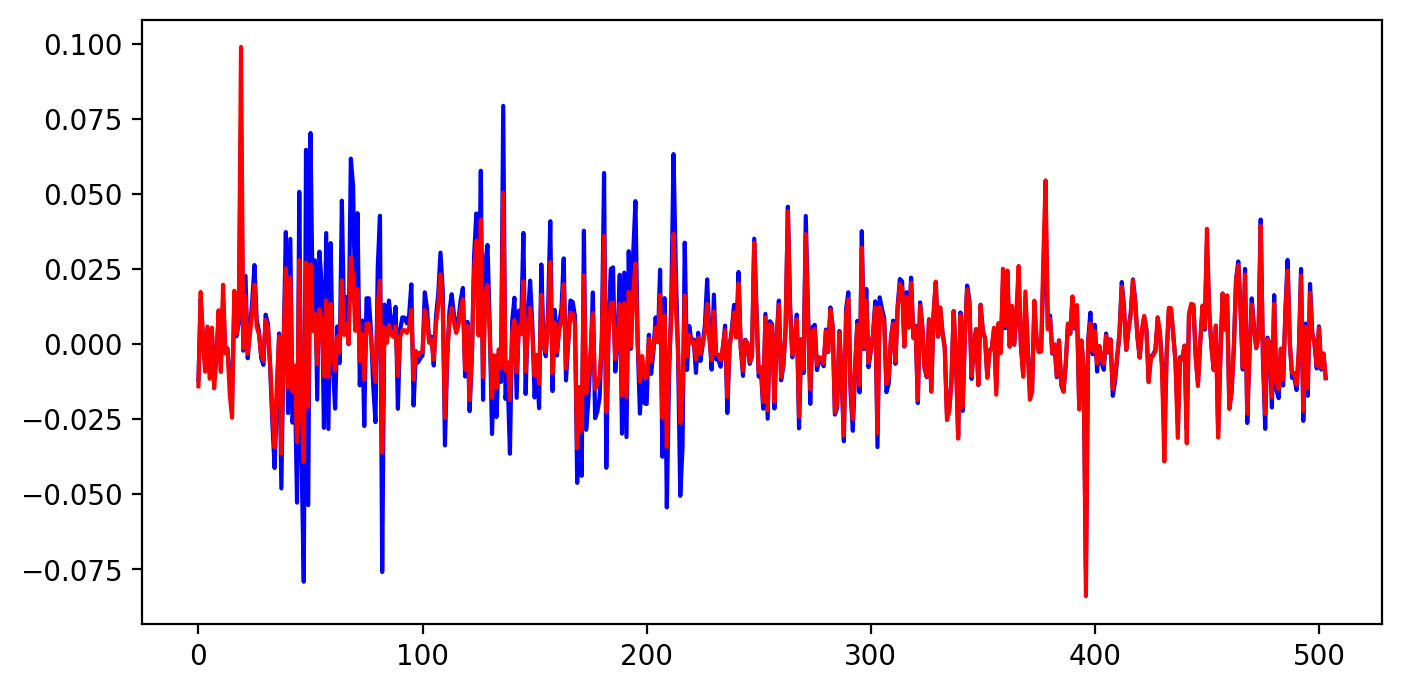

In [23]:
days = 504 # I choose a higher N to really see the effect
lamb = 0.94
older_returns = AMZN_returns.values[(-days - 1- 200):(-days - 1)]/100
older_returns = pd.DataFrame(older_returns)
init_vol = 0.015
init_vol = np.std(older_returns)
variance_ewma = init_vol**2
for returns in older_returns.values:
    variance_ewma = lamb * variance_ewma + (1 - lamb) * returns**2


historical_returns = AMZN_returns.values[-days:]/100
historical_returns = pd.DataFrame(historical_returns)

variances_ewma = np.zeros((days + 1, 1))
variances_ewma[0,:] = variance_ewma
for (i, returns) in enumerate(historical_returns.values):
  variances_ewma[i+1] = lamb * variances_ewma[i] + (1 - lamb) * returns**2

volatilities_ewma = variances_ewma ** 0.5

scaling_factors = volatilities_ewma[-1]/volatilities_ewma
adjusted_returns =  scaling_factors[:-1] * historical_returns

plt.figure(figsize=(8,4), dpi=200)
plt.plot(historical_returns, color = 'blue', label = "Returns")
plt.plot(adjusted_returns, color = 'red', label = "Returns")



In [24]:
portfolioAtDayN = 100000 # Suppose we invest 100.000$ on day n
alpha = 0.05 # "We are (1-alpha) sure that the loss will not exceed .."

# We can use the percentile (and lower interpolation - if you are curious about this, check the definition (19.2). Otherwise just accept it.)
VaR_95_percentage = -np.percentile(adjusted_returns.values, math.floor(alpha*100), interpolation='lower')
a= adjusted_returns.values
VaR_95_USD = portfolioAtDayN*VaR_95_percentage
scenarios = np.sort(adjusted_returns) # This is not working - it's not sorting?!
# When we have sorted, it's also easy to find ES. You could also do something similar to the example in RM page 556.
ES_95_percentage = -np.mean(scenarios[0:math.floor(days*(alpha))])
ES_95_USD = portfolioAtDayN * ES_95_percentage

print("1 day (percentage) {}%-VaR: {} pct.".format(int((1-alpha)*100), round(VaR_95_percentage*100, 2)))
print("1 day (USD) {}%-VaR: {} USD".format(int((1-alpha)*100), round(VaR_95_USD)))
print("1 day (percentage) {}%-ES: {} pct.".format(int((1-alpha)*100), round(ES_95_percentage*100, 2)))
print("1 day (USD) {}%-ES: {} USD".format(int((1-alpha)*100), round(ES_95_USD)))

# Saving these into a matrix
Results[5,0] = round(VaR_95_USD)
Results[5,1] = round(ES_95_USD)

# 99% VaR
alpha = 0.01 # "We are (1-alpha) sure that the loss will not exceed .."
VaR_99_percentage = -np.percentile(adjusted_returns, math.floor(alpha*100), interpolation='lower')
VaR_99_USD = portfolioAtDayN*VaR_99_percentage
ES_99_percentage = -np.mean(scenarios[0:math.floor(days*(alpha))])
ES_99_USD = portfolioAtDayN * ES_99_percentage

Results[5,2] = round(VaR_99_USD)
Results[5,3] = round(ES_99_USD)

1 day (percentage) 95%-VaR: 2.32 pct.
1 day (USD) 95%-VaR: 2321 USD
1 day (percentage) 95%-ES: -0.42 pct.
1 day (USD) 95%-ES: -420 USD


## 9) Backtesting

We will use the parametric approach with normality assumption to find volatilities.

In [16]:
portfolioAtDayN = 100000 # Suppose we invest 100.000$ on day n
days_estimate = 252
testing_period = 252
alpha1 = 0.05 # "We are (1-alpha)% sure that the loss will not exceed .."
alpha2 = 0.01 # "We are (1-alpha)% sure that the loss will not exceed .."

VaR_95_1 = np.zeros(testing_period)
ES_95_1 = np.zeros(testing_period)
VaR_99_1 = np.zeros(testing_period)
ES_99_1 = np.zeros(testing_period)
exceedance_95 = np.zeros(testing_period) 
exceedance_99 = np.zeros(testing_period) 
loss = np.zeros(testing_period)
for i in range(0,testing_period,1):

  mean_return = 0 # Assumption
  used_returns = AMZN_returns.values[-(testing_period-i+days_estimate):-(testing_period-i)]
  volatility = np.std(used_returns)
  VaR_95_percentage = -volatility*sps.norm.ppf(alpha1, loc=mean_return, scale=1)/100
  VaR_95 = portfolioAtDayN*VaR_95_percentage
  ES_95_percentage = -(volatility*(sps.norm.pdf(sps.norm.ppf(alpha1, loc=mean_return, scale=1)))/alpha1)/100
  ES_95 = portfolioAtDayN*ES_95_percentage
  VaR_99_percentage = -volatility*sps.norm.ppf(alpha2, loc=mean_return, scale=1)/100
  VaR_99 = portfolioAtDayN*VaR_99_percentage
  ES_99_percentage = -(volatility*(sps.norm.pdf(sps.norm.ppf(alpha2, loc=mean_return, scale=1)))/alpha2)/100
  ES_99 = portfolioAtDayN*ES_99_percentage
  VaR_95_1[i] = VaR_95
  ES_95_1[i] = ES_95
  VaR_99_1[i] = VaR_99
  ES_99_1[i] = ES_99
    
  loss[i] = -portfolioAtDayN*AMZN_returns.values[-(testing_period-i)]/100
  exceedance_95[i] = VaR_95 < loss[i]
  exceedance_99[i] = VaR_99 < loss[i]
  
# The final VaR estimate (that we cannot test before seing another realisation of data). Coincides with the number calculated in 4)   
mean_return = 0 # Assumption
used_returns = AMZN_returns.values[-(days_estimate):]
volatility = np.std(used_returns)
VaR_95_percentage = -volatility*sps.norm.ppf(alpha1, loc=mean_return, scale=1)/100
VaR_95 = portfolioAtDayN*VaR_95_percentage
ES_95_percentage = -(volatility*(sps.norm.pdf(sps.norm.ppf(alpha1, loc=mean_return, scale=1)))/alpha1)/100
ES_95 = portfolioAtDayN*ES_95_percentage
VaR_99_percentage = -volatility*sps.norm.ppf(alpha2, loc=mean_return, scale=1)/100
VaR_99 = portfolioAtDayN*VaR_99_percentage
ES_99_percentage = (volatility*(sps.norm.pdf(sps.norm.ppf(alpha2, loc=mean_return, scale=1)))/alpha2)/100
ES_99 = portfolioAtDayN*ES_99_percentage


Then we summarize our findings in a plot.

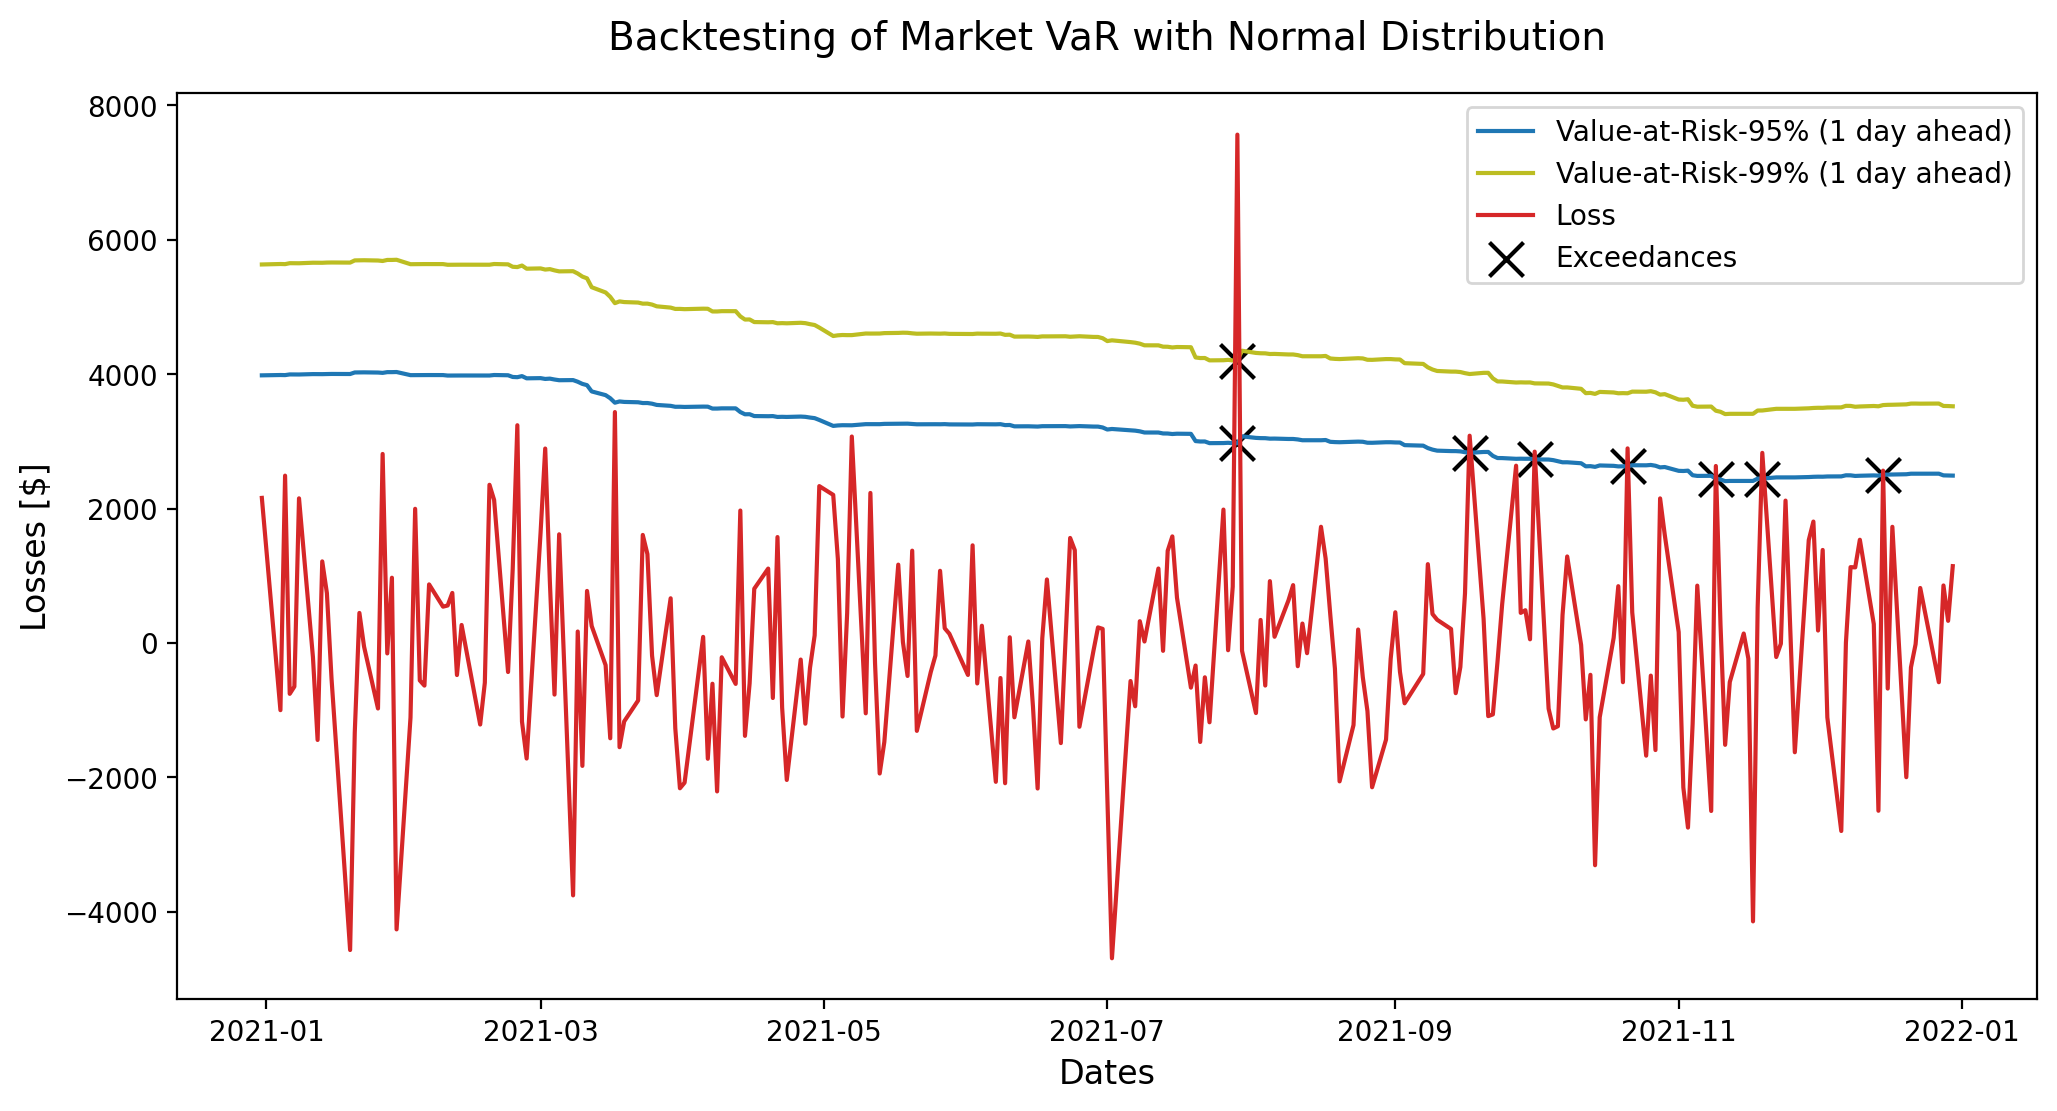

In [17]:
plt.figure(figsize=(12,6), dpi=200)
plt.plot(AMZN_returns.index[-(testing_period+1):-1], VaR_95_1, c = mcolors.TABLEAU_COLORS['tab:blue'], label = "Value-at-Risk-95% (1 day ahead)")
plt.plot(AMZN_returns.index[-(testing_period+1):-1], VaR_99_1, c = mcolors.TABLEAU_COLORS['tab:olive'], label = "Value-at-Risk-99% (1 day ahead)")
plt.plot(AMZN_returns.index[-(testing_period+1):-1], loss, c = mcolors.TABLEAU_COLORS['tab:red'], label = "Loss")
plt.scatter(AMZN_returns.index[-(testing_period+1):-1][exceedance_95 == 1], VaR_95_1[exceedance_95 == 1], s = 100*1.5, marker="x", color="black", label="Exceedances")
plt.scatter(AMZN_returns.index[-(testing_period+1):-1][exceedance_99 == 1], VaR_99_1[exceedance_99 == 1], s = 100*1.5, marker="x", color="black")
plt.xlabel("Dates", fontsize = 12)
plt.ylabel("Losses [$]", fontsize = 12)
plt.title("Backtesting of Market VaR with Normal Distribution", fontsize = 14, y=1.03)
plt.legend()
plt.show()

In [29]:
VaR_95_1.resize((testing_period+1,1), refcheck=False)
VaR_99_1.resize((testing_period+1,1), refcheck=False)
ES_95_1.resize((testing_period+1,1), refcheck=False)
ES_99_1.resize((testing_period+1,1), refcheck=False)
VaR_95_1[testing_period] = VaR_95
ES_95_1[testing_period] = ES_95
VaR_99_1[testing_period] = VaR_99
ES_99_1[testing_period] = ES_99

### Coverage Test

Then we use the proposed statistical tests. The exeedances $I_{X,t}$ are assumed to be i.i.d. Bernoulli distributed.

In [30]:
N = testing_period

pi_exp_alpha = alpha1
pi_obs_alpha = np.sum(exceedance_95 == 1)/N
n1_alpha = np.sum(exceedance_95 == 1)
n0_alpha = np.sum(exceedance_95 == 0)

LR_uc_VaR_95 = -2*np.log(((pi_exp_alpha**n1_alpha)*(1-pi_exp_alpha)**n0_alpha)/((pi_obs_alpha**n1_alpha)*(1-pi_obs_alpha)**n0_alpha))

pi_exp_alpha = alpha2
pi_obs_alpha = np.sum(exceedance_99 == 1)/N
n1_alpha = np.sum(exceedance_99 == 1)
n0_alpha = np.sum(exceedance_99 == 0)

LR_uc_VaR_99 = -2*np.log(((pi_exp_alpha**n1_alpha)*(1-pi_exp_alpha)**n0_alpha)/((pi_obs_alpha**n1_alpha)*(1-pi_obs_alpha)**n0_alpha))

print("The critical value for Chi-Squared at {}-% significance level is: {}".format(int((0.1)*100), sps.chi2.ppf((1-0.1), 1, loc=0, scale=1)))
print("The critical value for Chi-Squared at {}-% significance level is: {}".format(int((alpha1)*100), sps.chi2.ppf((1-alpha1), 1, loc=0, scale=1)))
print("The critical value for Chi-Squared at {}-% significance level is: {}".format(int((alpha2)*100), sps.chi2.ppf((1-alpha2), 1, loc=0, scale=1)))
print("The corresponding likelihood ratio statistic for VaR95 is: {}".format((LR_uc_VaR_95)))
print("The corresponding likelihood ratio statistic for VaR99 is: {}".format((LR_uc_VaR_99)))

The critical value for Chi-Squared at 10-% significance level is: 2.705543454095404
The critical value for Chi-Squared at 5-% significance level is: 3.841458820694124
The critical value for Chi-Squared at 1-% significance level is: 6.6348966010212145
The corresponding likelihood ratio statistic for VaR95 is: 3.100971227588913
The corresponding likelihood ratio statistic for VaR99 is: 1.2007243088320814


See the discussion on significance level in PC page 303. We would accept both models at 5 % significance. But only the VaR99 if we increase the significance level to 10%.

### Clusters

In [32]:
N = testing_period

# test for independence for 95

T_01 = 0 # violation after non-violation
T_00 = 0 # non-violation after non-violation
T_11 = 0 # violation after violation
T_10 = 0 # non-violation after violation

for i in range(1, N):
    if exceedance_95[i]:
        if exceedance_95[i - 1]:
            T_11 += 1 
        else:
            T_01 += 1 
    else:
        if exceedance_95[i - 1]:
            T_10 += 1
        else:
            T_00 += 1

T_1 = exceedance_95[1:].sum()
T_0 = N-1 - T_1
pi_01 = T_01/(T_00 + T_01)
pi_11 = T_11/(T_10 + T_11)
pi_obs = T_1/(N-1)

LR_ind_VaR_95 = -2*np.log(((pi_obs**T_1)*(1-pi_obs)**T_0)/((pi_01**T_01*(1-pi_01)**T_00)*(pi_11**T_11*(1-pi_11)**T_10)))

# repeat for 99

T_01 = 0 # violation after non-violation
T_00 = 0 # non-violation after non-violation
T_11 = 0 # violation after violation
T_10 = 0 # non-violation after violation

for i in range(1, N):
    if exceedance_99[i]:
        if exceedance_95[i - 1]:
            T_11 += 1 
        else:
            T_01 += 1 
    else:
        if exceedance_95[i - 1]:
            T_10 += 1
        else:
            T_00 += 1

T_1 = exceedance_99[1:].sum()
T_0 = N-1 - T_1
pi_01 = T_01/(T_00 + T_01)
pi_11 = T_11/(T_10 + T_11)
pi_obs = T_1/(N-1)



LR_ind_VaR_99 = -2*np.log(((pi_obs**T_1)*(1-pi_obs)**T_0)/((pi_01**T_01*(1-pi_01)**T_00)*(pi_11**T_11*(1-pi_11)**T_10)))

print("The critical value for Chi-Squared at {}-% significance level is: {}".format(int((0.1)*100), sps.chi2.ppf((1-0.1), 1, loc=0, scale=1)))
print("The critical value for Chi-Squared at {}-% significance level is: {}".format(int((alpha1)*100), sps.chi2.ppf((1-alpha1), 1, loc=0, scale=1)))
print("The critical value for Chi-Squared at {}-% significance level is: {}".format(int((alpha2)*100), sps.chi2.ppf((1-alpha2), 1, loc=0, scale=1)))
print("The corresponding likelihood ratio statistic for VaR95 is: {}".format((LR_ind_VaR_95)))
print("The corresponding likelihood ratio statistic for VaR99 is: {}".format((LR_ind_VaR_99)))

The critical value for Chi-Squared at 10-% significance level is: 2.705543454095404
The critical value for Chi-Squared at 5-% significance level is: 3.841458820694124
The critical value for Chi-Squared at 1-% significance level is: 6.6348966010212145
The corresponding likelihood ratio statistic for VaR95 is: 0.40169445604267023
The corresponding likelihood ratio statistic for VaR99 is: 0.05668403345635624


Both levels do not experience clusters

### Combined Test

In [33]:
LR_cc_95 = LR_uc_VaR_95+LR_ind_VaR_95
LR_cc_99 = LR_uc_VaR_99+LR_ind_VaR_99

print("The critical value for Chi-Squared at {}-% significance level is: {}".format(int((0.1)*100), sps.chi2.ppf((1-0.1), 2, loc=0, scale=1)))
print("The critical value for Chi-Squared at {}-% significance level is: {}".format(int((alpha1)*100), sps.chi2.ppf((1-alpha1), 2, loc=0, scale=1)))
print("The critical value for Chi-Squared at {}-% significance level is: {}".format(int((alpha2)*100), sps.chi2.ppf((1-alpha2), 2, loc=0, scale=1)))
print("The corresponding likelihood ratio statistic for VaR95 is: {}".format(LR_cc_95))
print("The corresponding likelihood ratio statistic for VaR99 is: {}".format(LR_cc_99))

The critical value for Chi-Squared at 10-% significance level is: 4.605170185988092
The critical value for Chi-Squared at 5-% significance level is: 5.991464547107979
The critical value for Chi-Squared at 1-% significance level is: 9.21034037197618
The corresponding likelihood ratio statistic for VaR95 is: 3.5026656836315833
The corresponding likelihood ratio statistic for VaR99 is: 1.2574083422884377


The combined test is accepted.

## 10) Portfolio

We will investigate Bristol-Myers Squibb Company as well. The first task is to find VaR based on a 100,000 USD investment and afterwards find VaR for a portfolio of the two investments.

In [34]:
days_estimate = 252 # change this if you like - to keep consistency with above
alpha = 0.05 # "We are (1-alpha) sure that the loss will not exceed .."
#mean_return = 0 # Assumption - we could estimate this as well by commenting out the relevant one.
mean_return = np.mean(BMY_returns.values[-days_estimate:]/100) # comment out the relevant one

volatility = np.std(BMY_returns.values[-days_estimate:]/100) # this is the standard deviation of daily returns
VaR_95_percentage = -volatility*sps.norm.ppf(alpha, loc=mean_return, scale=1)
VaR_95_USD = portfolioAtDayN*VaR_95_percentage
ES_95_percentage = volatility*(sps.norm.pdf(sps.norm.ppf(alpha, loc=mean_return, scale=1)))/(alpha)
ES_95_USD = portfolioAtDayN*ES_95_percentage


print("1 day (USD) {}%-VaR: {} USD".format(int((1-alpha)*100), round(VaR_95_USD)))
print("1 day (USD) {}%-ES: {} USD".format(int((1-alpha)*100), round(ES_95_USD)))

# 99% VaR
alpha = 0.01 # "We are (1-alpha) sure that the loss will not exceed .."
VaR_99_percentage = -volatility*sps.norm.ppf(alpha, loc=mean_return, scale=1)
VaR_99_USD = portfolioAtDayN*VaR_99_percentage
ES_99_percentage = volatility*(sps.norm.pdf(sps.norm.ppf(alpha, loc=mean_return, scale=1)))/(alpha)
ES_99_USD = portfolioAtDayN*ES_99_percentage



1 day (USD) 95%-VaR: 1928 USD
1 day (USD) 95%-ES: 2419 USD


In [35]:
# Considering the last 252 days for both assets
portfolio_returns = stock_data.pct_change().dropna()

w = np.array([0.5, 0.5])
SIGMA = portfolio_returns.tail(days_estimate).cov()
RHO = portfolio_returns.tail(days_estimate).corr()
sigma_P = np.sqrt(np.dot(np.dot(w, SIGMA), w))


In [36]:
portfolioAtDayN = 100000*2 # Suppose we invest 100000$ on day n in each stock
days_estimate = 252
alpha = 0.05 # "We are (1-alpha)% sure that the loss will not exceed .."
mean_return = 0 # Assumption

volatility = sigma_P # volatility of the returns of a portfolio with weight allocation as above
VaR_PF_percentage = -volatility*sps.norm.ppf(alpha, loc=mean_return, scale=1)
VaR_PF_95 = portfolioAtDayN*VaR_PF_percentage
ES_PF_percentage = volatility*(sps.norm.pdf(sps.norm.ppf(alpha, loc=mean_return, scale=1)))/(alpha)
ES_PF_95 = portfolioAtDayN*ES_PF_percentage

print("1 day (USD) portfolio {}%-VaR: {} USD".format(int((1-alpha)*100), round(VaR_PF_95)))
print("1 day (USD) portfolio {}%-ES: {} USD".format(int((1-alpha)*100), round(ES_PF_95)))

alpha = 0.01 # "We are (1-alpha)% sure that the loss will not exceed .."

VaR_PF_percentage = -volatility*sps.norm.ppf(alpha, loc=mean_return, scale=1)
VaR_PF_99 = portfolioAtDayN*VaR_PF_percentage
ES_PF_percentage = volatility*(sps.norm.pdf(sps.norm.ppf(alpha, loc=mean_return, scale=1)))/(alpha)
ES_PF_99 = portfolioAtDayN*ES_PF_percentage

print("1 day (USD) portfolio {}%-VaR: {} USD".format(int((1-alpha)*100), round(VaR_PF_99)))
print("1 day (USD) portfolio {}%-ES: {} USD".format(int((1-alpha)*100), round(ES_PF_99)))

1 day (USD) portfolio 95%-VaR: 3203 USD
1 day (USD) portfolio 95%-ES: 4017 USD
1 day (USD) portfolio 99%-VaR: 4530 USD
1 day (USD) portfolio 99%-ES: 5190 USD


CONCLUSION: 

Risk decreases when combined. 95 VaR when investing 100,000 in each of the stocks are 2491 resp 1928. The VaR of the portfolio is 3203. The drop is significant as the correlation between the assets is very low (around 0).

NOTE:

Contrary to what the diversification principle indicate, the risk (measured in terms of VaR) can sometimes increase when assets are combined. This is because Value-at-Risk lack the $\textit{subadditivity}$ property.

$$
VaR(X_{1} + X_{2}) \nleq VaR(X_{1}) + VaR(X_{2})
$$

This means that it is not a $\textit{coherent}$ risk measure. However, when normality is assumed it is coherent. In that case

$$
VaR(X_{1} + X_{2}) \leq VaR(X_{1}) + VaR(X_{2})
$$

ES is coherent, which is why academics aregue for the use of ES. 

## 11) Can ES be backtested?

Yes, it can. Until recently (less than 10 years ago), the broad view was that it could not. However, as the linked articles show there are ways to do it - and it does not have to be that complicated.

Master Thesis: https://www.math.kth.se/matstat/seminarier/reports/M-exjobb15/150826a.pdf

Paper from MSCI: https://www.msci.com/documents/10199/22aa9922-f874-4060-b77a-0f0e267a489b